# Regressione non Lineare (parte 2)

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Setup

- Importare i package necessari e configurare l'output di matplotlib

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

## Caso di studio: predizione consumo elettricità

- Carichiamo i dati già visti nei laboratori precedenti: per ogni giorno degli anni dal 2015 al 2017 abbiamo la temperatura media in una città e il picco registrato di consumo di corrente elettrica
  - con l'opzione `index_col` specifichiamo che la colonna `date` costituisce l'indice del DataFrame
  - con `parse_dates` indichiamo che i suoi valori vanno interpretati come date

In [179]:
import os.path
if not os.path.exists("power.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/vpaM1", "power.csv")

In [180]:
data = pd.read_csv("https://git.io/vpaM1", index_col="date", parse_dates=["date"])

In [181]:
data.head(8)

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0
2015-01-06,2.122799,-6.7
2015-01-07,2.243265,-9.4
2015-01-08,2.240975,-8.9


- Vogliamo costruire un modello che consenta la predizione del consumo di corrente sulla base della temperatura in un qualsiasi giorno dell'anno
- Come nello scorso laboratorio, suddividiamo i dati in
  - un _training set_ `*_train` con i dati relativi all'anno 2015
  - un _validation set_ `*_val` con i dati relativi agli anni 2016 e 2017
- Per ciascuno estraiamo
  - una matrice `X_*` $N\times 1$ con le osservazioni delle variabili indipendenti: in questo caso una sola, la temperatura
  - un vettore `y_*` con gli $N$ corrispondenti valori della variabile dipendente: i consumi

In [182]:
is_train = data.index.year < 2016
X_train = data.loc[is_train, ["temp"]]
y_train = data.loc[is_train, "demand"]
X_val = data.loc[~is_train, ["temp"]]
y_val = data.loc[~is_train, "demand"]

## Valutazione dei modelli

- Abbiamo visto tre diverse metriche per la valutazione dell'accuratezza dei modelli di regressione
  - l'_errore quadratico medio_, usato nella discesa del gradiente ma più difficilmente interpretabile
  - l'_errore relativo_, che indica intuitivamente la percentuale di errore del modello
  - il _coefficiente R²_, che esprime l'accuratezza con un indice tra 0 e 1
- Riprendiamo la funzione `print_eval` definita nella scorsa esercitazione per calcolare e stampare le tre metriche su un set di dati e un modello indicati

In [183]:
# MSE e R^2 sono incluse in scikit-learn
from sklearn.metrics import mean_squared_error, r2_score

# definisco l'errore relativo
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

- Riprendiamo anche la funzione `plot_model_on_data` per visualizzare un grafico del modello addestrato sovrapposto ai dati

In [184]:
def plot_model_on_data(X, y, model=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(X, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_y = model.predict(line_x[:, None])
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Temperatura (°C)"); plt.ylabel("Consumi (GW)")

## Esercizio 1: Ripasso modelli

Addestrare sul training set creato sopra tre modelli diversi con le seguenti configurazioni, per ciascuno stampare le misure di valutazione sul validation set e visualizzare il modello sovrapposto ad esso

- **(1a)** regressione lineare semplice
- **(1b)** regressione polinomiale di grado 2
- **(1c)** regressione polinomiale di grado 3 con standardizzazione delle feature

In [185]:
# sono eseguiti quì tutti gli import necessari da scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

   Mean squared error: 0.097075
       Relative error: 15.39235%
R-squared coefficient: 0.095201


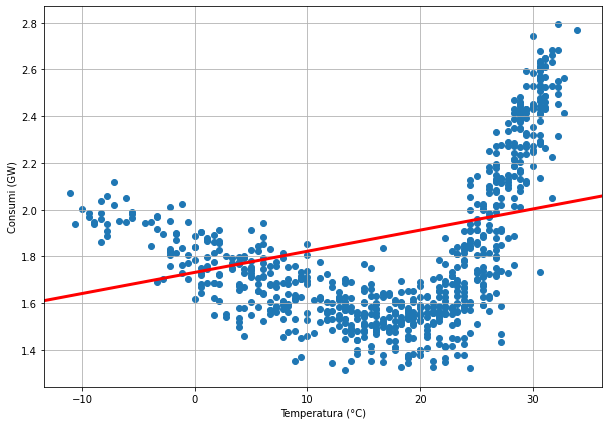

In [186]:
regLin = LinearRegression()
regLin.fit(X_train, y_train)
print_eval(X_val, y_val, regLin)
plot_model_on_data(X_val, y_val, regLin)

   Mean squared error: 0.037151
       Relative error: 8.89180%
R-squared coefficient: 0.65373


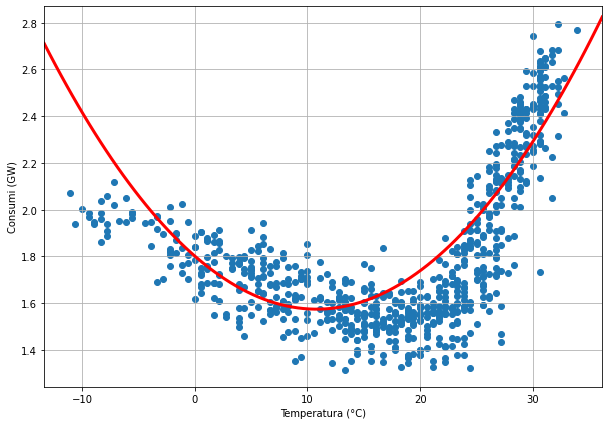

In [187]:
regPoly2 = Pipeline([
    ("poly",PolynomialFeatures(degree=2,include_bias=False)),
    ("linReg2",LinearRegression())
])
regPoly2.fit(X_train, y_train)
print_eval(X_val, y_val, regPoly2)
plot_model_on_data(X_val, y_val, regPoly2)

   Mean squared error: 0.025885
       Relative error: 7.18888%
R-squared coefficient: 0.75874


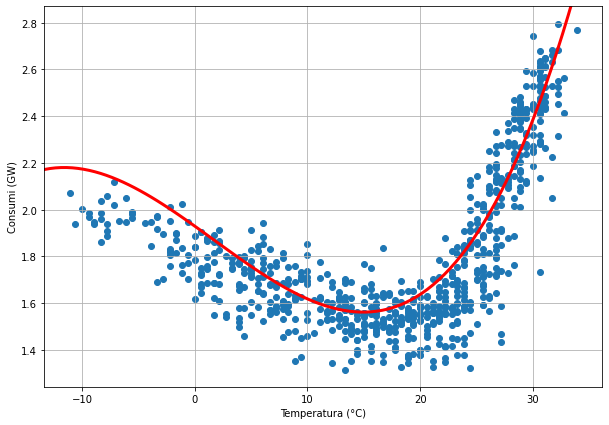

In [188]:
regPoly3 = Pipeline([
    ("poly",PolynomialFeatures(degree=3,include_bias=False)),
    ("scale", StandardScaler()),
    ("linReg3",LinearRegression())
])
regPoly3.fit(X_train, y_train)
print_eval(X_val, y_val, regPoly3)
plot_model_on_data(X_val, y_val, regPoly3)

## Regolarizzazione e regressione ridge

- Abbiamo visto come l'addestramento di un modello si compia minimizzando l'errore sui dati di addestramento, dato da
$$ E = \mathrm{media}\left(\left(\mathbf{X}\mathbf{\theta}-\mathbf{y}\right)^2\right) $$
- Per l'esattezza, la formula su cui si basa `LinearRegression` è
$$ E = \left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 $$
- Dove la _norma euclidea_ (o _norma 2_) $\left\Vert\mathbf{x}\right\Vert_2$ di un vettore $\mathbf{x}$ di $n$ elementi è
$$ \left\Vert\mathbf{x}\right\Vert_2 = \sqrt{\sum_{i=1}^n x_i^2} = \sqrt{x_1^2+\ldots+x_n^2} $$
- Tuttavia, questo non garantisce l'accuratezza del modello in generale
- Soprattutto se il modello ha molti parametri, è possibile che questi vengano "forzati" a funzionare bene sui dati d'addestramento, rendendo però il modello poco accurato in generale

- Addestriamo ad esempio un modello polinomiale di grado 30 con standardizzazione

In [189]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=30, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=30, include_bias=False)),
                ('scale', StandardScaler()), ('linreg', LinearRegression())])

- Valutiamone le misure di accuratezza sia sul training set che sul validation set

In [190]:
print_eval(X_train, y_train, prm)

   Mean squared error: 0.020568
       Relative error: 6.16186%
R-squared coefficient: 0.808


In [191]:
print_eval(X_val, y_val, prm)

   Mean squared error: 14.789
       Relative error: 12.40754%
R-squared coefficient: -136.84


- La differenza tra le misure suggerisce che il modello sia stato addestrato "troppo bene" sul training set ma non sia abbastanza generale (_overfitting_)

- A dimostrazione, si veda il grafico del modello sovrapposto ai dati del training set

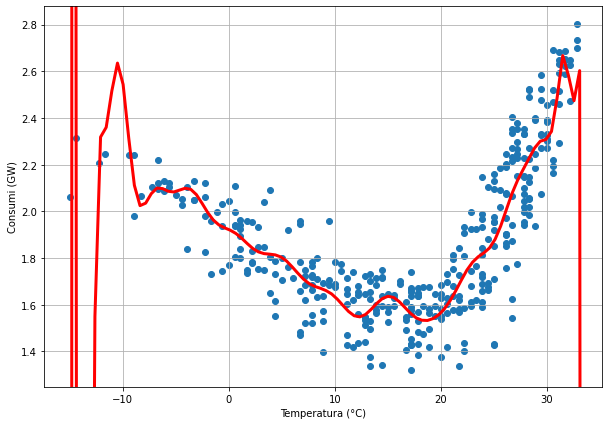

In [192]:
plot_model_on_data(X_train, y_train, prm)

- Soprattutto nella parte a sinistra, si nota che il modello è stato ottimizzato per minimizzare l'errore anche in casi estremi del training set

- Vediamo ora il modello sovrapposto al validation set

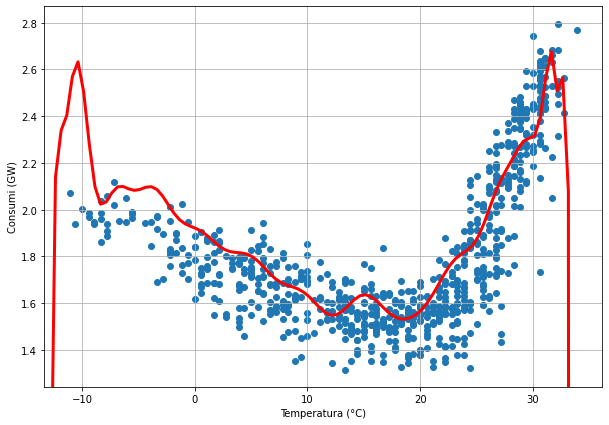

In [193]:
plot_model_on_data(X_val, y_val, prm)

- Si nota che nei casi estremi del validation set, diversi da quelli del training set, l'errore del modello è molto alto

- Vediamo quali sono i coefficienti del modello addestrato

In [194]:
prm.named_steps["linreg"].coef_

array([-2.18974476e-01, -1.60445532e+00, -6.28075976e+01,  5.96355150e+02,
        5.61781307e+03, -5.15743870e+04, -1.91108122e+05,  2.12206090e+06,
        2.16366849e+06, -4.87455064e+07,  3.19698977e+07,  6.40162665e+08,
       -1.27571401e+09, -4.37152349e+09,  1.64348320e+10,  6.74608056e+09,
       -1.03849385e+11,  1.10966026e+11,  2.76150216e+11, -7.67499174e+11,
        2.29319035e+11,  1.60483366e+12, -2.64897865e+12,  7.78818555e+11,
        2.72518340e+12, -4.52406849e+12,  3.55096907e+12, -1.61569423e+12,
        4.11447697e+11, -4.57588383e+10])

- I coefficienti per i termini di grado più alto sono molto alti in valore assoluto (fino a ${10}^{12}$)
- Questo causa l'andamento irregolare del modello nei casi estremi e i conseguenti errori
- Come evitare che i coefficienti assumano tali valori?

- La **_regolarizzazione_** modifica la funzione d'errore su cui si basa l'addestramento, aggiungendo una penalità per valori estremi dei parametri del modello
- Nella regolarizzazione _L2_, la più comune, la penalità è proporzionale al quadrato della norma euclidea del vettore $\mathbf{\theta}$ dei parametri
  - in questo modo parametri molto alti in valore assoluto sono molto penalizzati
- La regressione _ridge_ consiste nella regressione lineare con applicata la regolarizzazione L2, utilizzando quindi la seguente funzione d'errore:
$$ E = \left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 + \alpha\left\Vert\mathbf{\theta}\right\Vert_2^2 $$
- $\alpha$ è un parametro impostabile dall'utente che controlla il "peso" della regolarizzazione
  - tali parametri impostabili sono a volte detti _iperparametri_ per distinguerli dai parametri addestrabili del modello

- Per eseguire la regressione ridge usiamo un modello `Ridge`
- Alla creazione del modello è possibile specificare il peso della regolarizzazione con l'opzione `alpha`
- Per il resto l'API della classe `Ridge` è identica a quella di `LinearRegression`, possiamo quindi sostituirla nella pipeline

In [195]:
from sklearn.linear_model import Ridge

rrm = Pipeline([
    ("poly",   PolynomialFeatures(degree=30, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge(alpha=1))  # <-- sostituice LinearRegression()
])
rrm.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=30, include_bias=False)),
                ('scale', StandardScaler()), ('linreg', Ridge(alpha=1))])

- Verifichiamo i coefficienti del modello addestrato

In [196]:
rrm.named_steps["linreg"].coef_

array([-0.31325676, -0.02583932,  0.16619334,  0.12873744,  0.15304114,
        0.10838303,  0.08446827,  0.04675489,  0.01952785, -0.00549028,
       -0.02267416, -0.03463496, -0.04084124, -0.0427362 , -0.04099736,
       -0.03668078, -0.03057249, -0.02344422, -0.01590952, -0.00848886,
       -0.00158713,  0.00448139,  0.00948767,  0.01327275,  0.01573763,
        0.01683213,  0.01654581,  0.01489957,  0.01193869,  0.00772681])

- Vediamo che questa volta sono tutti inferiori a 1 in valore assoluto, per effetto della regolarizzazione

- Con tali, coefficienti, il modello ha un comportamento regolare anche per casi estremi, come si può vedere dal grafico

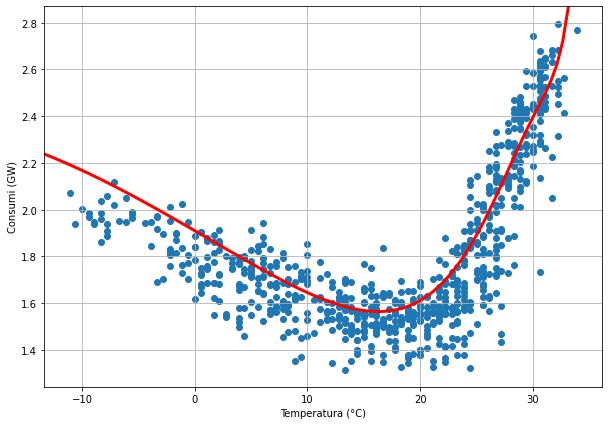

In [197]:
plot_model_on_data(X_val, y_val, rrm)

- Verifichiamo l'accuratezza su training e validation set

In [198]:
print_eval(X_train, y_train, rrm)

   Mean squared error: 0.020643
       Relative error: 6.14974%
R-squared coefficient: 0.8073


In [199]:
print_eval(X_val, y_val, rrm)

   Mean squared error: 0.024567
       Relative error: 6.91874%
R-squared coefficient: 0.77102


- Vediamo che le misure sul training set sono di poco peggiori, ma quelle sul validation set (più importanti) sono nettamente migliori

## Esercizio 2: Regressione polinomiale al variare di grado e regolarizzazione

- **(2a)** Definire una funzione `test_regression` con parametri `degree` e `alpha` che
  - definisca un modello di regressione polinomiale di grado `degree` con standardizzazione dei dati e regolarizzazione L2 con peso `alpha`
  - _(già implementato)_ addestri tale modello sui dati `X_train`, `y_train`
  - _(già implementato)_ restituisca il coefficiente R² del modello calcolato sui dati `X_val`, `y_val`
- **(2b)** Generare una lista, array o serie di valori restituiti dalla funzione con `alpha=0.01` e `degree` variabile con valori da 3 a 30
- **(2c)** Ripetere il punto 2b con `alpha=10`
- **(2d)** Visualizzare i risultati in un grafico a linea (`plt.plot`)

In [200]:
def test_regression(degree, alpha):
    rrm = Pipeline([
        ("poly",   PolynomialFeatures(degree=degree, include_bias=False)),
        ("scale",  StandardScaler()),
        ("linreg", Ridge(alpha=alpha))  # <-- sostituice LinearRegression()
    ])
    rrm.fit(X_train, y_train)
    return rrm.score(X_val, y_val)

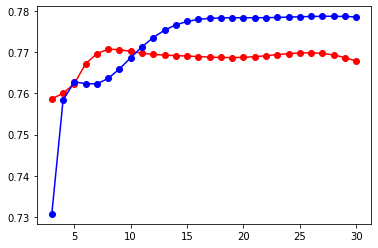

In [201]:
# ok
alpha = 0.01
degrees = []
coef_R2 = []
for deg in range(3,31):
    degrees.append(deg)
    coef_R2.append(test_regression(deg, alpha))
plt.plot(degrees, coef_R2, 'r-o');
alpha = 10
degrees = []
coef_R2 = []
for deg in range(3,31):
    degrees.append(deg)
    coef_R2.append(test_regression(deg, alpha))
plt.plot(degrees, coef_R2, 'b-o');

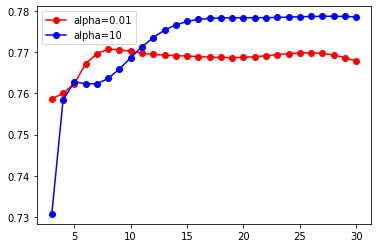

In [202]:
# soluzione ottima
min_deg, max_deg = 3, 30
a1, a2 = 0.01, 10
degrees = range(min_deg, max_deg + 1)
score_1 = [test_regression(degree, a1) for degree in degrees]
score_2 = [test_regression(degree, a2) for degree in degrees]
plt.plot(degrees, score_1, 'r-o');
plt.plot(degrees, score_2, 'b-o');
plt.legend([f"alpha={a1}",f"alpha={a2}"]);

## Caso di studio: Predizione dei prezzi delle case

- Riprendiamo dalla scorsa esercitazione il dataset relativo ai prezzi delle case
- Forniamo tale dataset all'URL https://git.io/fjGjx già adattato per essere caricato con `read_csv` con le opzioni di default

In [203]:
import os.path
if not os.path.exists("housing.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/fjGjx", "housing.csv")

In [204]:
housing = pd.read_csv("housing.csv")

### Lista delle variabili

- CRIM: tasso di criminalità pro capite per zona
- ZN: proporzione terreno residenziale per lotti maggiori di 25.000 piedi quadrati (circa 2300 m2)
- INDUS: proporzione di acri industriali non commerciali per città
- CHAS: variabile fittizia Charles River, 1 se il tratto affianca il fiume, altrimenti 0
- NOX: concentrazione di ossido d’azoto (parti per 10 milioni)
- RM: numero medio di stanze per abitazione
- AGE: proporzione delle unità abitate costruite prima del 1940
- DIS: distanze pesate verso i cinque uffici di collocamento di Boston
- RAD: indice di accessibilità rispetto alle grandi vie radiali di comunicazione
- TAX: tasso di imposte sulla casa per 10.000 dollari
- PTRATIO: rapporto allievi-docenti per città
- B: 1000(Bk - 0.63)2, dove Bk è la proporzione di persone di origine afroamericana
- LSTAT: percentuale di popolazione con basso reddito
- **MEDV: valore mediano delle abitazioni di proprietà in migliaia di dollari**
  - vogliamo stimare il valore di questa variabile in funzione delle altre

In [205]:
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


- Estraiamo dal frame
  - la serie `y` con i valori della variabile `MEDV` da prevedere
  - il frame `X` con i valori di tutte le altre variabili, utilizzabili per la predizione

In [206]:
y = housing["MEDV"]
X = housing.drop(columns="MEDV")

- Dividiamo i dati caricati casualmente in training e validation set con la funzione `train_test_split`
  - con `test_size` indichiamo quanti dati vanno nel validation set, i restanti andranno nel training set
  - con `random_state` fissiamo un seed per la suddivisione casuale
  - la funzione mescola i dati di `X` e `y` in modo congiunto, mantenendo la corrispondenza esistente tra le posizioni dei dati

In [207]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=1/3, random_state=42)

## Analisi coefficienti modelli

- Addestriamo e verifichiamo l'accuratezza di tre diversi modelli sui dati:
  - **(a)** regressione lineare semplice
  - **(b)** regressione lineare con regolarizzazione L2 (regressione ridge), assumendo $\alpha=1$
  - **(c)** regressione lineare con standardizzazione delle feature

In [208]:
model_a = LinearRegression()
model_a.fit(X_train, y_train)
print_eval(X_val, y_val, model_a)

   Mean squared error: 20.595
       Relative error: 16.20789%
R-squared coefficient: 0.72621


In [209]:
model_b = Ridge(alpha=10)
model_b.fit(X_train, y_train)
print_eval(X_val, y_val, model_b)

   Mean squared error: 21.615
       Relative error: 16.55757%
R-squared coefficient: 0.71265


In [210]:
model_c = Pipeline([
    ("scale", StandardScaler()),
    ("lr", LinearRegression())
])
model_c.fit(X_train, y_train)
print_eval(X_val, y_val, model_c)

   Mean squared error: 20.595
       Relative error: 16.20789%
R-squared coefficient: 0.72621


- Visualizziamo ora in un unico frame i coefficienti di tutti e tre i modelli (una riga per variabile, una colonna per modello)

In [211]:
pd.DataFrame({
    "linear": model_a.coef_,
    "ridge": model_b.coef_,
    "scaled": model_c.named_steps["lr"].coef_
}, index=X.columns)

,linear,ridge,scaled
CRIM,-0.129470,-0.120803,-0.995690
ZN,0.037960,0.041276,0.872971
INDUS,0.060978,-0.003992,0.424808
CHAS,3.213498,2.143922,0.857462
NOX,-16.499614,-1.462094,-1.943856
RM,3.911519,3.632845,2.820988
AGE,-0.012602,-0.022260,-0.351939
DIS,-1.427742,-1.207228,-3.063072
RAD,0.239546,0.220856,2.069621
TAX,-0.008180,-0.010126,-1.356887


- In tutti e tre i modelli, dai segni dei coefficienti possiamo vedere quali fenomeni influiscono positivamente e negativamente sul prezzo
  - ad es. il prezzo delle case è più alto se vicine al fiume (`CHAS`), mentre decresce con la criminalità (`CRIM`)
- Nella regressione ridge i valori assoluti più alti sono ridotti (es. `NOX` e `RM`)
- Con la standardizzazione delle feature otteniamo valori su scale simili, che possiamo confrontare alla pari
  - ad es. negli altri modelli il coefficiente di `NOX` è alto in valore assoluto perché i valori di tale variabile sono bassi (la media è circa 0.55, contro quelle superiori a 3 delle altre variabili)
  - nel modello con standardizzazione assumono invece più peso il numero di stanze (`RM`) e la distanza dagli uffici di collocamento (`DIS`)

## Regressione Lasso

- La regolarizzazione L2 impedisce che i parametri del modello assumano valori troppo alti
- I valori dei parametri sono comunque tutti non nulli, tutte le variabili vengono coinvolte nella predizione
- Vorremmo addestrare un modello meno complesso, dove alcuni parametri hanno valori nulli, **ignorando completamente le variabili meno rilevanti**
  - ad es. variabili con valori dipendenti da altre (_multicollinearità_)
- Questo si può ottenere tramite la regolarizzazione L1, basata sulla norma 1, definita su un vettore $\mathbf{x}$ di $n$ elementi come
$$ \left\Vert\mathbf{x}\right\Vert_1 = \sum_{i=1}^n{\left\vert x_i\right\vert} = \left\vert x_1\right\vert+\ldots+\left\vert x_n\right\vert $$

- La regressione _lasso_ consiste nella regressione lineare con regolarizzazione L1, basata quindi sul minimizzare la funzione d'errore
$$ E = \frac{1}{2m}\left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 + \alpha\left\Vert\mathbf{\theta}\right\Vert_1 $$
- Come per la regressione ridge, il parametro $\alpha$ controlla il peso della regolarizzazione
- La regressione lasso si esegue usando un modello `Lasso`, su cui possiamo impostare come in `Ridge` il parametro `alpha`

In [212]:
from sklearn.linear_model import Lasso
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=1))
])
model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('regr', Lasso(alpha=1))])

- Vediamo i coefficienti del modello risultante

In [213]:
pd.Series(model.named_steps["regr"].coef_, X.columns)

CRIM      -0.000000
ZN         0.000000
INDUS     -0.000000
CHAS       0.270752
NOX       -0.000000
RM         2.641503
AGE       -0.000000
DIS       -0.000000
RAD       -0.000000
TAX       -0.000000
PTRATIO   -1.200172
B          0.311046
LSTAT     -3.814854
dtype: float64

- La regolarizzazione L1 ha contribuito ad annullare quanti più coefficienti possibile, creando un modello che considera solo 3 variabili
- Ma qual'è l'accuratezza di tale modello?

In [214]:
print_eval(X_val, y_val, model)

   Mean squared error: 25.984
       Relative error: 19.41638%
R-squared coefficient: 0.65457


- L'accuratezza è peggiore rispetto ai casi precedenti: in questo caso la regolarizzazione è stata eccessiva

- Cosa succede diminuendo il parametro `alpha`, ovvero il peso della regolarizzazione?

In [215]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=0.2)) # <-- cambiato da 1
])
model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('regr', Lasso(alpha=0.2))])

In [216]:
pd.Series(model.named_steps["regr"].coef_, X.columns)

CRIM      -0.394705
ZN         0.192948
INDUS     -0.000000
CHAS       0.827011
NOX       -0.812358
RM         2.944153
AGE       -0.000000
DIS       -1.514910
RAD        0.000000
TAX       -0.000000
PTRATIO   -1.698942
B          0.842742
LSTAT     -4.009724
dtype: float64

- I coefficienti non nulli sono aumentati da 5 a 11

In [217]:
print_eval(X_val, y_val, model)

   Mean squared error: 22.527
       Relative error: 16.62391%
R-squared coefficient: 0.70053


- L'accuratezza è di poco inferiore a quella ottenuta con gli altri modelli
- Questo modello richiede però solo 9 variabili invece di 13

## Elastic Net

- La regressione _elastic net_ combina insieme le regolarizzazioni L2 e L1 usate in ridge e lasso
- Si applica in scikit-learn tramite la classe `ElasticNet`, per cui l'errore è calcolato come:
$$ E = \underbrace{\frac{1}{2m} ||X\theta - y||_2 ^ 2}_{\text{errore sui dati}} + \underbrace{\alpha \rho ||\theta||_1}_{\text{L1}} + \underbrace{\frac{\alpha(1-\rho)}{2} ||\theta||_2 ^ 2}_{\text{L2}} $$
- I parametri impostabili sono
  - `alpha` ($\alpha$) che determina il peso generale della regolarizzazione
  - `l1_ratio` ($\rho$, compreso tra 0 e 1) che determina il peso di L1 relativo al totale (con $\rho=1$ si ha la regressione lasso, con $\rho=0$ la ridge)

In [224]:
from sklearn.linear_model import ElasticNet
model = Pipeline([
    ("scale",  StandardScaler()),
    ("regr", ElasticNet(alpha=0.2, l1_ratio=0.1))
])
model.fit(X_train, y_train)
print(len(X_val), len(y_val))
print_eval(X_val, y_val, model)
# plot_model_on_data(X_val, y_val, model)

169 169
   Mean squared error: 22.092
       Relative error: 16.18298%
R-squared coefficient: 0.70631


## Esercizio 3: Elastic Net con pesi separati

- **(3a)** Definire una funzione `elastic_net_with_alphas` che restituisca un modello elastic net (non addestrato) con pesi dati separatamente per la regolarizzazione L2 e L1
  - si ricordi che il parametro `alpha` è la somma dei due pesi
- **(3b)** Servendosi di tale funzione, addestrare e validare un modello elastic net con $\alpha_{L2}=1, \alpha_{L1}=0.1$ e standardizzazione delle feature

In [219]:
def elastic_net_with_alphas(alpha_l2, alpha_l1):
    alpha = alpha_l1 + alpha_l2
    l1_ratio = alpha_l1 / alpha
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

In [223]:
model_en = elastic_net_with_alphas(1,0.1)
pl = Pipeline([
    ("scale",  StandardScaler()),
    ("ElasticNet", model_en)
])
pl.fit(X_train, y_train)
print_eval(X_val, y_val, pl)
print(len(X_val), len(y_val))
# plot_model_on_data(X_val, y_val, pl)

   Mean squared error: 28.122
       Relative error: 18.96992%
R-squared coefficient: 0.62615
169 169


## FINO QUI VIDEO LEZIONE 1h 25min

## Regressione polinomiale multivariata

- Abbiamo visto in precedenza la regressione polinomiale su una sola variabile $X$ (univariata), corrispondente alla regressione lineare sulle variabili $X,X^2,X^3,\ldots$
- Per generare queste variabili utilizziamo il filtro `PolynomialFeatures`
- Siano date ad esempio due osservazioni di una variabile...

In [ ]:
sample = np.array([ [ 2],
                    [-3] ])

- Possiamo ottenere ad es. le potenze fino al 4° grado
  - `include_bias=True` specifica di non includere il termine di grado 0

In [ ]:
poly = PolynomialFeatures(degree=4, include_bias=False)
poly.fit_transform(sample)
#         X   X^2   X^3   X^4

- In presenza di più di una variabile, la regressione polinomiale genera tutti i possibili termini fino al grado impostato, includendo anche **termini basati su più variabili**
- Vediamo un esempio con 2 generiche variabili $A$ e $B$

In [ ]:
#                     A   B
sample = np.array([ [ 2, -3],
                    [ 4, -5] ])

- Applicando il filtro `PolynomialFeatures` con grado 2...

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit_transform(sample)
#         A     B    A^2   A*B   B^2

- Le variabili generate (escludendo il grado nullo) sono 5: $A,B,A^2,AB,B^2$
- Oltre ai quadrati delle singole variabili abbiamo quindi anche i prodotti tra di esse

- Possiamo usare il metodo `get_feature_names_out` del filtro per avere un array delle variabili calcolate (`get_feature_names` in versioni più vecchie di scikit-learn)
  - il filtro deve già essere stato "addestrato" con `fit` o `fit_transform`
  - è possibile passare una lista di nomi delle variabili originali, altrimenti sono usati `x0`, `x1`, ...

In [ ]:
poly.get_feature_names_out()

In [ ]:
poly.get_feature_names_out(["A", "B"])

- Aumentando il grado massimo, le variabili generate **aumentano rapidamente**
- Ad esempio, aumentando il grado da 2 a 3...

In [ ]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(sample)

- ...generiamo 9 variabili, ovvero:

In [ ]:
poly.get_feature_names_out(["A", "B"])

- Cosa succede con un numero iniziale di variabili più alto?
- Selezioniamo ad esempio dalle variabili X del dataset le 5 feature che avevano coefficiente non nullo nella prima regressione Lasso

In [ ]:
# la lista delle feature da considerare è:
Xsub_feats = ["CHAS", "RM", "PTRATIO", "B", "LSTAT"]
# creo una selezione sia dal training che dal validation set
Xsub_train = X_train[Xsub_feats]
Xsub_val = X_val[Xsub_feats]
# stampo il numero di colonne
Xsub_train.shape[1]

- Generando le feature polinomiali con grado massimo 2...

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit_transform(Xsub_train).shape[1]

- ...otteniamo 20 feature distinte!
- Le feature includono infatti tutte le possibili coppie di variabili, oltre ai quadrati di ciascuna

In [ ]:
poly.get_feature_names_out(Xsub_train.columns)

- Aumentando ulteriormente il grado, il numero di variabili cresce esponenzialmente

In [ ]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(Xsub_train).shape[1]

In [ ]:
poly = PolynomialFeatures(degree=4, include_bias=False)
poly.fit_transform(Xsub_train).shape[1]

In [ ]:
# possiamo usare un ciclo for per testare rapidamente valori successivi
for degree in range(3, 9):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    feats_count = poly.fit_transform(Xsub_train).shape[1]
    print(f"{degree}° grado: {feats_count} variabili")

- Questa crescita è ancora più evidente con la matrice completa `X_train`, con 13 variabili

In [ ]:
X_train.shape[1]

- Generando le feature polinomiali con grado massimo 2 otteniamo 104 feature

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit_transform(X_train).shape[1]

- Aumentando ulteriormente il grado, il numero di variabili cresce enormemente
  - con grado 10 si supera il milione di variabili

In [ ]:
for degree in range(3, 8):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    feats_count = poly.fit_transform(X_train).shape[1]
    print(f"{degree}° grado: {feats_count} variabili")

- All'aumentare delle variabili, aumenta il tempo necessario per l'addestramento del modello
- Prendiamo ad esempio come riferimento un modello ElasticNet polinomiale con standardizzazione delle feature generate

In [ ]:
def poly_std_elasticnet(degree):
    return Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("std",  StandardScaler()),
        ("regr", ElasticNet(alpha=0.5, l1_ratio=0.2))
    ])

- Eseguiamo la prova su un modello di grado 2 sia col sottoinsieme di 5 feature indicato sopra che con tutte le feature
- Usiamo il comando "magico" `%time` per riportare in output il tempo di esecuzione

In [ ]:
model = poly_std_elasticnet(2)
%time model.fit(Xsub_train, y_train)
print_eval(Xsub_val, y_val, model)

In [ ]:
model = poly_std_elasticnet(2)
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

- L'addestramento richiede una frazione di secondo, anche per via del numero limitato di istanze

- Verifichiamo ora cosa accade in entrambi i casi con grado 5

In [ ]:
model = poly_std_elasticnet(5)
%time model.fit(Xsub_train, y_train)
print_eval(Xsub_val, y_val, model)

In [ ]:
model = poly_std_elasticnet(5)
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

- L'accuratezza del modello migliora sensibilmente, ma **con tempi di addestramento molto superiori**
  - più di 10 volte superiori con 5 feature
  - più di 100 volte superiori con 13 feature
  - con dataset più grandi, avremmo tempi di addestramento insostenibili

## Regressione con funzioni kernel

- Nella regressione polinomiale si eseguono prodotti tra dati con dimensioni aggiunte e rappresentate esplicitamente
- Le _funzioni kernel_ permettono di calcolare gli stessi prodotti senza calcolare esplicitamente le dimensioni aggiunte
- Questo permette di ottenere **modelli non lineari senza l'aggiunta di variabili**
- Esistono diverse funzioni kernel utilizzabili con diversi parametri impostabili
- Ad esempio, il kernel polinomiale è definito dalla formula
$$ K(\mathbf{a},\mathbf{b}) = \left(\mathbf{a}\cdot\mathbf{b}+c\right)^d $$
  - $d$ e $c$ sono parametri del kernel, in particolare $d$ è il grado del polinomio

- La classe `KernelRidge` implementa la regressione ridge con l'applicazione di una funzione kernel
- Col parametro `kernel` si indica il tipo di kernel con una stringa, ad es. `"poly"` per un kernel polinomiale
- Ulteriori parametri riguardano il kernel, per quello polinomiale sono `degree` ($d$) e `coef0` ($c$)

In [ ]:
from sklearn.kernel_ridge import KernelRidge
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly", degree=5))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

- Abbiamo ottenuto un'accuratezza più elevata rispetto ai modelli lineari, ma in tempi molto più brevi rispetto alla regressione polinomiale

- Aumentando arbitrariamente il grado del polinomio, il tempo impiegato per l'addestramento non cambia
  - in questo caso comunque un grado alto non porta ad un modello accurato

In [ ]:
from sklearn.kernel_ridge import KernelRidge
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly", degree=15))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

- Va però ricordato che la complessità cresce quadraticamente col numero di istanze di training
- Ad esempio, addestrando un modello su _tutti_ i dati invece che sul solo training set, quindi sul 50\% di istanze in più...

In [ ]:
from sklearn.kernel_ridge import KernelRidge
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly", degree=5))
])
%time model.fit(X, y)
print_eval(X_val, y_val, model)

- ... il tempo necessario è circa il doppio

- Possiamo testare anche funzioni kernel diverse, ad esempio RBF (_radial basis function_)
  - RBF ha valori tanto più elevati quanto più i valori X sono vicini a 0 (ovvero la media, usando dati standardizzati)
- La funzione RBF ha la forma di una gaussiana, di cui si può impostare l'ampiezza col parametro `gamma`

In [ ]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="rbf", gamma=0.01))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

- In questo caso specifico il kernel RBF non funziona bene tanto quanto il polinomiale

## k-Fold Cross Validation

- La _cross validation_ si riferisce in generale alla valutazione di un modello di predizione su dati differenti rispetto a quelli su cui è addestrato
- Finora l'abbiamo svolta usando il semplice metodo _hold-out_
  - i dati sono suddivisi casualmente in _training set_ e _validation set_ con proporzioni configurabili
  - un modello è addestrato sul training set e validato sul validation set
- Il metodo _k-fold_ è un'alternativa al metodo hold-out per valutare l'accuratezza di un modello
  - i dati sono divisi causalmente in k gruppi (_fold_)
  - ciascun gruppo è validato su un modello addestrato su tutti gli altri gruppi
  - i risultati dei singoli test sono aggregati
- scikit-learn fornisce un supporto generico per la cross-validation di modelli tramite diversi metodi

- Per prima cosa va creato un oggetto che definisce il metodo di cross-validation da applicare
- Usiamo ad esempio un oggetto della classe `KFold`
  - il primo parametro è il numero di fold (k) da usare
  - specifichiamo inoltre che i dati sono distribuiti casualmente e il seed da usare

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=42)

- Gli oggetti di questo tipo forniscono un metodo `split`, che dato un dataset genera le suddivisioni training/validation secondo la configurazione data
  - per ogni suddivisione sono dati un array di etichette delle righe da includere nel training set (`train_index`) e l'array complementare di etichette delle righe da includere nel validation set (`val_index`)

In [ ]:
for i, (train_index, val_index) in enumerate(kf.split(X, y), start=1):
    print(f"Fold {i}: {len(train_index)} istanze di training, {len(val_index)} istanze di validazione")
    # per ottenere ad es. X_train: X[train_index]

- Definiamo un modello da validare, ad es. il modello kernel ridge visto sopra

In [ ]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly", degree=5))
])

- Per eseguire la CV usiamo quindi la funzione `cross_validate`, a cui passiamo in input:
  - la definizione di un modello, di cui viene addestrata una copia con la stessa configurazione per ciascun fold
  - i dati, divisi come per `fit` in valori di variabili indipendenti (X) e dipendente (y)
  - l'oggetto che definisce il metodo di CV, in questo caso l'istanza di `KFold`
  - l'opzione `return_train_score=True` per ottenere la valutazione di ogni modello anche sui dati di addestramento

In [ ]:
from sklearn.model_selection import cross_validate
cv_result = cross_validate(model, X, y, cv=kf, return_train_score=True)

- Otteniamo un dizionario con un vettore per ciascuna misura estratta, ciascuno ha un valore per ogni fold

In [ ]:
cv_result

- Per operare facilmente, raccogliamo i dati in un frame

In [ ]:
cv_table = pd.DataFrame(cv_result)
cv_table

- Per ognuno dei 5 fold vediamo riportati
  - i secondi impiegati per l'addestramento (`fit_time`) e la validazione (`score_time`) del modello
  - lo score calcolato su training set (`train_score`) e validation set (`test_score`)
- Lo score è quello calcolato dal metodo `score` del modello, ovvero il coefficiente R²

- Per avere un dato generale sulla bontà del modello, possiamo calcolare media e deviazione standard degli score

In [ ]:
cv_table[["train_score", "test_score"]].agg(["mean", "std"])

- Tale valutazione è più affidabile di quella col metodo hold-out, ottenuta da un singolo modello
- Ci permette inoltre di valutare la "robustezza" del modello, ovvero quanto l'accuratezza sia stabile addestrandosi su set di dati diversi

## Esercizio 4: Cross-validation su modello kernel ridge

- **(4a)** Definire un modello di regressione kernel ridge su feature standardizzate con kernel polinomiale di 3° grado e $\alpha=10$
- **(4b)** Eseguire la cross-validation del modello, utilizzando 5 fold dell'intero set di dati (`X` e `y`) generati dall'oggetto `kf` definito sopra
- **(4c)** Calcolare la media e la deviazione standard dei punteggi R² ottenuti dalla validazione di ciascun fold

## Ricerca degli iperparametri con grid search

- Sui modelli utilizzati finora abbiamo impostato manualmente i valori di diversi iperparametri
  - grado della regressione polinomiale, peso della regolarizzazione, ...
- L'accuratezza del modello può dipendere fortemente da questi valori
- Scelto un generico modello da utilizzare (es. regressione polinomiale o kernel ridge), vorremmo **individuare i valori degli iperparametri che ne massimizzino l'accuratezza**
- scikit-learn fornisce un supporto per eseguire automaticamente la cross validation di un modello con diversi valori degli iperparametri tramite la _grid search_

- Consideriamo ad esempio un modello _elastic net_ di cui fissiamo arbitrariamente il parametro `l1_ratio`

In [ ]:
model = ElasticNet(l1_ratio=0.2)

- Vorremmo trovare il migliore valore possibile del parametro `alpha` tra un insieme di valori possibili, ovvero:

In [ ]:
candidate_alphas = [0.1, 1, 10]

- Creiamo una _griglia_ dei parametri, ovvero un dizionario in cui associamo ai nomi dei parametri variabili i valori che possono assumere
- In questo caso abbiamo un unico parametro variabile, `alpha`

In [ ]:
grid = {"alpha": candidate_alphas}

- Definiamo ora un modello `GridSearchCV` indicando
  - il modello "base" con i parametri fissati a priori
  - la griglia dei parametri variabili
  - un metodo `cv` di cross validation da usare

In [ ]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model, grid, cv=kf)

- Come per i modelli base, usiamo il metodo `fit` per eseguire l'addestramento, passando la matrice X e il vettore y
- Per ogni valore possibile di `alpha`, scikit-learn esegue la cross-validation per calcolare il punteggio R² medio del modello con quel valore di `alpha`

In [ ]:
gs.fit(X_train, y_train);

- In seguito ai test, il modello impostato viene (di default) riaddestrato su tutti i dati forniti, usando gli iperparametri che han dato il miglior punteggio medio
- Il modello finale è accessibile all'attributo `gs_best_estimator_`

In [ ]:
gs.best_estimator_

- Dall'attributo `best_params_` possiamo vedere quali sono i valori selezionati dalla griglia degli iperparametri per tale modello

In [ ]:
gs.best_params_

- L'oggetto `GridSearchCV` addestrato può essere usato come un normale modello di predizione, le chiamate a `predict` e altri metodi sono girate al `best_estimator_`

In [ ]:
# prezzo predetto per la prima riga del validation set
gs.predict(X_val.iloc[[0]])

In [ ]:
# equivalente a
gs.best_estimator_.predict(X_val.iloc[[0]])

- Possiamo valutare il modello sul validation set "esterno", non utilizzato nella grid search

In [ ]:
print_eval(X_val, y_val, gs)

- L'attributo `cv_results_` fornisce risultati dettagliati su tutti gli iperparametri testati
- Come per `cross_validate`, raccogliamo i risultati in un `DataFrame` per visualizzarli meglio

In [ ]:
pd.DataFrame(gs.cv_results_)

I dati riportati per ciascun test includono:
- `{mean|std}_{fit|score}_time`: media/dev. standard dei tempi di addestramento/valutazione sui diversi fold
- `param_X`: valore del parametro X
- `params`: dizionario col valore di tutti i parametri
- `splitN_test_score`: punteggio della valutazione sull'N-esimo fold
- `{mean|std}_test_score`: media/dev. standard dei punteggi sui diversi fold
- `rank_test_score`: ranking del punteggio, 1 è il migliore

- Cosa succede con due iperparametri variabili?
- Oltre a 3 valori possibili per `alpha`, impostiamo 3 valori possibili anche per `l1_ratio`

In [ ]:
model = ElasticNet()
grid = {
    "alpha":    [0.1, 1, 10],
    "l1_ratio": [0.1, 0.2, 0.3]
}
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train);

- Visualizzo i risultati ordinati per punteggio R² medio decrescente

In [ ]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

- scikit-learn ha generato e testato **tutte le combinazioni possibili** dei valori degli iperparametri, in tutto 3×3 = 9 configurazioni

### Grid search su pipeline

- Possiamo usare `GridSearchCV` anche con una pipeline, testando diversi valori anche per i parametri dei filtri
- Consideriamo ad esempio un modello polinomiale con regolarizzazione L2, su cui sono variabili
  - il grado del polinomio (attributo `degree` del filtro `poly`)
  - il peso della regolarizzazione (attributo `alpha` del modello `regr`)

In [ ]:
model = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr",  Ridge())
])

- Per riferirsi ai parametri dei singoli componenti, usiamo la notazione `componente__parametro` _(con DUE underscore in mezzo)_

In [ ]:
grid = {
    "poly__degree": [2, 3],      # <- grado polinomio
    "regr__alpha":  [0.1, 1, 10] # <- regolarizzazione
}

- Il resto del procedimento rimane invariato

In [ ]:
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train);
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

- Nella pipeline possiamo impostare un intero componente come parametro variabile, con la possibilità di rimuoverlo impostandolo a `None`
- Possiamo ad esempio testare un modello con e senza standardizzazione delle feature

In [ ]:
model = Pipeline([
    ("scale", None),   # uso None come segnaposto
    ("regr",  Ridge())
])
grid = {
    # scale = standardizzazione oppure nulla
    "scale": [None, StandardScaler()],
    "regr__alpha": [0.1, 1, 10]
}
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train);
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

## Esercizio 5: Grid search su regressione kernel ridge

- **(5a)** Creare una funzione `grid_test` che, presi in input un modello e una griglia di parametri
  - esegua una grid search con `X_train`, `y_train` come dati di addestramento con modello e parametri forniti, usando cross-validation a 5 fold
  - stampi (`print(...)`) il dizionario con gli iperparametri selezionati del modello migliore
  - stampi le misure di accuratezza (`print_eval`) sui dati `X_val`, `y_val`
- **(5b)** Testare con la funzione sopra un modello di regressione elastic net polinomiale con
  - grado 2 o 3
  - standardizzazione delle feature generate
  - `alpha` pari a 0.1, 1 o 10
  - `l1_ratio` pari a 0.1, 0.25 o 0.5
- **(5c)** Testare con la funzione sopra un modello kernel ridge con
  - standardizzazione dei dati
  - kernel polinomiale di grado compreso tra 2 e 10
  - `alpha` (regolarizzazione) pari a 0.01, 0.1, 1 o 10

In [ ]:
def grid_test(model, grid):
    ...

## Nested cross-validation

- Sopra abbiamo validato il risultato finale della grid search su un validation set separato
- La _nested cross-validation_ prevede che siano generati **k fold "esterni"** su tutti i dati disponibili e che **per ciascuno** si esegua il tuning degli iperparametri con una cross validation "interna" usando le parti di training dei fold esterni
- I criteri con cui si eseguono le cross validation esterna ed interna possono differire, es. diverso numero di fold
- Ipotizziamo ad esempio di usare 3 fold esterni e 5 interni

In [ ]:
outer_cv = KFold(3, shuffle=True, random_state=42)
inner_cv = KFold(5, shuffle=True, random_state=42)

## Esercizio 6: Nested cross validation

Completare l'implementazione una funzione `nested_cv` che esegua la nested cross validation di un modello `model` con griglia di parametri variabili `grid`
- _(già implementato)_ predisporre una lista vuota in cui salvare i punteggi ottenuti su ogni fold esterno
- _(già implementato)_ usare un ciclo `for` per iterare tutti i fold esterni (T, V) del dataset `X`, `y`
  - il metodo `split` di `outer_cv` fornisce per ogni fold gli indici delle istanze di training e di validation
- su ciascun fold esterno, eseguire la grid search con modello e parametri dati in ingresso alla funzione sui dati T, applicando `inner_cv` come cross validation
- per ogni modello generato, salvare nella lista di punteggi il R² ottenuto dalla validazione sui dati V
- _(già implementato)_ restituire la lista alla fine del ciclo

Testare la funzione su uno dei modelli usati sopra

In [ ]:
def nested_cv(model, grid):
    results = []
    for train_indices, val_indices in outer_cv.split(X, y):
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
        ...
    return results